In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bibtexparser
from collections import Counter
!pip install bibtexparser

all_references = "../references.bib"
selected_references = "../screen/selected_references.bib"
csf_mapping = './nist-csf-mapping.csv'
coding = '../extraction/coding.csv'

In [4]:
# Load the CSV file
df = pd.read_csv(csf_mapping)

df.head()

FileNotFoundError: [Errno 2] No such file or directory: './nist-csf-mapping.csv'

In [669]:
# Adjusting code to include the mapping and presence logic
df['Function'] = df['subcategory_desc'].str.extract('([A-Z]+)\.')  # Extract the Function (e.g., ID or RC)
df['Abbreviation'] = df['subcategory_desc'].str.extract('([A-Z]+\.[A-Z]+)-')[0]
df['Subcategory'] = df['subcategory_desc'].str.extract('(([A-Z]+\.[A-Z]+)-[0-9]+)')[0]

# Filter rows with valid Abbreviation and Subcategory values and make a copy to avoid SettingWithCopyWarning
category_rows = df.dropna(subset=['Abbreviation', 'Subcategory']).copy()

# Adjust Presence detection to account for any value, not just greater than 0
category_rows['Presence'] = (category_rows.iloc[:, 3:] == 'x').any(axis=1)

# Create the new DataFrame with the required information
all_categories_df = pd.DataFrame({
    'Function': category_rows['Function'],
    'Abbreviation': category_rows['Abbreviation'],
    'Subcategory': category_rows['Subcategory'],
    'Presence': category_rows['Presence']
})

all_categories_df.reset_index(drop=True, inplace=True)  # Reset index if needed

# Define the mapping from Abbreviation to Function Category
abbreviation_function_map = {
    'ID': 'Identify',
    'DE': 'Detect',
    'PR': 'Protect',
    'RS': 'Respond',
    'RC': 'Recover'
}

# Apply mapping to update the 'Function' column
all_categories_df['Function'] = all_categories_df['Abbreviation'].str.split('.').str[0].map(abbreviation_function_map)

all_categories_df.head()

,Function,Abbreviation,Subcategory,Presence
0,Identify,ID.AM,ID.AM-1,True
1,Identify,ID.AM,ID.AM-2,True
2,Identify,ID.AM,ID.AM-3,True
3,Identify,ID.AM,ID.AM-4,True
4,Identify,ID.AM,ID.AM-5,True


In [657]:

# Assuming you have already extracted 'Function', 'Category', 'Subcategory', and 'Presence'

# Group by 'Function' and 'Category' and count the total number of subcategories and the number of fulfilled subcategories
category_counts = all_categories_df.groupby(['Function', 'Abbreviation']).agg(
    Total_Subcategories=('Subcategory', 'count'),
    Fulfilled_Subcategories=('Presence', 'sum')
)

# Calculate the percentage of fulfilled subcategories for each category
category_counts['fulfilled'] = (category_counts['Fulfilled_Subcategories'] / category_counts['Total_Subcategories']) * 100

# Drop unnecessary columns
category_counts.drop(columns=['Fulfilled_Subcategories'], inplace=True)

# Reset index to make 'Function' and 'Category' regular columns again
category_counts.reset_index(inplace=True)

category_counts.head()

,Function,Abbreviation,Total_Subcategories,fulfilled
0,Detect,DE.AE,5,100.000000
1,Detect,DE.CM,8,100.000000
2,Detect,DE.DP,5,100.000000
3,Identify,ID.AM,6,83.333333
4,Identify,ID.BE,5,100.000000


In [671]:
def plot_radar_chart(data, function):
    # Filter data for the given function
    function_data = data[data['Function'] == function]
    
    # Number of variables we're plotting
    num_vars = len(function_data['Abbreviation'])
    
    # Split the circle into even parts and save the angles 
    # so we know where to put each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # Make the plot continuous
    values = function_data['fulfilled'].tolist() + function_data['fulfilled'].tolist()[:1]
    angles += angles[:1]
    
    # Set figure and axis with a fixed size
    fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(polar=True))
    
    # Set equal aspect ratio to maintain consistency
    ax.set_aspect('equal')
    
    ax.fill(angles, values, alpha=0.1, label="Fulfilled Values", color=function_colors[function])
    ax.plot(angles, values, linewidth=1, color=function_colors[function])
    
    # Set yticklabels with percentage
    yticks = np.linspace(0, 100, 6)
    ax.set_yticks(yticks)
    ax.set_yticklabels(["{:.0f}%".format(y) for y in yticks], fontsize=20)
    
    # Set xticklabels with fontsize and fontweight
    ax.set_xticks(angles[:-1])
    category_labels = [f"{abbr}" for abbr, subcategories in zip(function_data['Abbreviation'], function_data['Total_Subcategories'])]
    
    # Calculate rotation angle based on the maximum label length
    max_label_length = max(len(label) for label in category_labels)
    rotation = 45 if max_label_length <= 10 else 90
    
    ax.set_xticklabels(category_labels, fontsize=20, rotation=rotation, ha='center', va='center')
    
    for label, angle_rad in zip(ax.get_xticklabels(), angles):
        angle_deg = np.degrees(angle_rad)
        if 0 <= angle_deg < 90:
            ha = 'left'
            va = 'bottom'
        elif 90 <= angle_deg < 180:
            ha = 'right'
            va = 'bottom'
        elif 180 <= angle_deg < 270:
            ha = 'right'
            va = 'top'
        else:
            ha = 'left'
            va = 'top'

        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)
    
    # Remove the border around the radar chart
    ax.spines['polar'].set_visible(False)
    
    # Adjust figure layout to ensure consistent size
    fig.tight_layout()
    
    # Adjust figure size here, after setting x-axis labels
    fig.set_size_inches(8, 7)

    # Adding a legend
    plt.tight_layout()
    
    # Export the plot as PDF
    plt.savefig(f'{function}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Define the color mapping for each function
#function_colors = {
#    'Detect': '#008080',  # blue
#    'Identify': '#008080',  # orange
#    'Protect': '#008080',  # green
#    'Respond': '#008080',  # red
#    'Recover': '#008080'  # purple
#}

# Define the color mapping for each function
function_colors = {
    'Detect': '#008080',  # blue
    'Identify': '#008080',  # orange
    'Protect': '#008080',  # green
    'Respond': '#008080',  # red
    'Recover': '#008080'  # purple
}

/var/folders/qb/z7q3w2md0c3c0s29ngj6p0600000gn/T/ipykernel_46176/1449897151.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


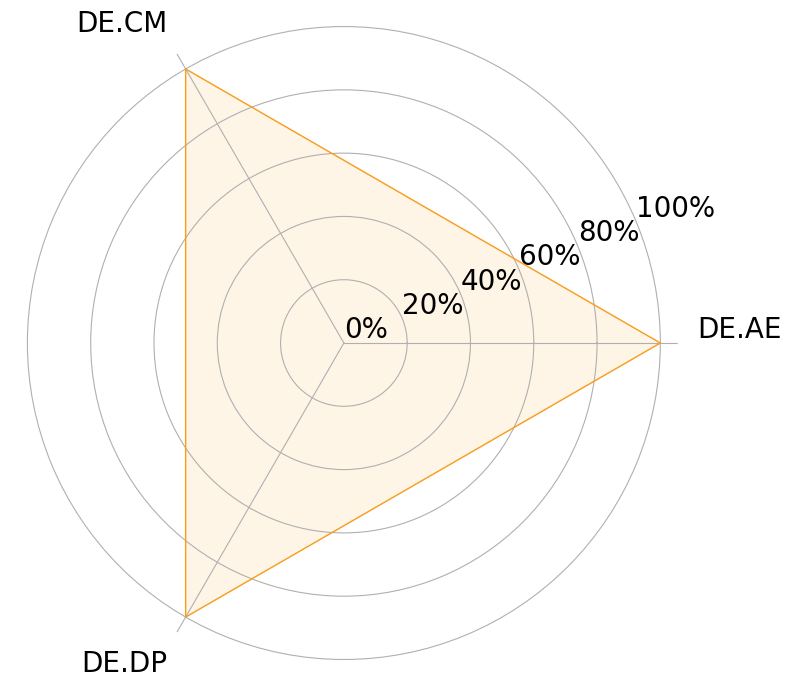

/var/folders/qb/z7q3w2md0c3c0s29ngj6p0600000gn/T/ipykernel_46176/1449897151.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


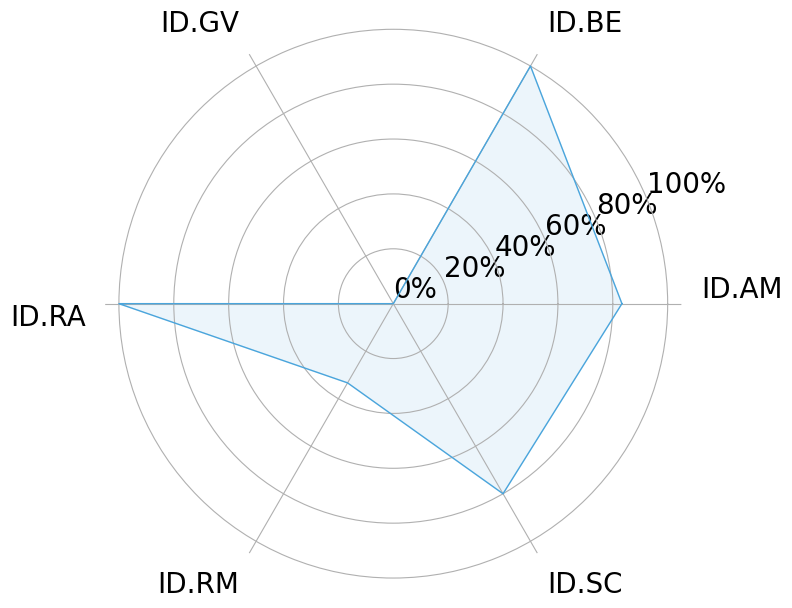

/var/folders/qb/z7q3w2md0c3c0s29ngj6p0600000gn/T/ipykernel_46176/1449897151.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


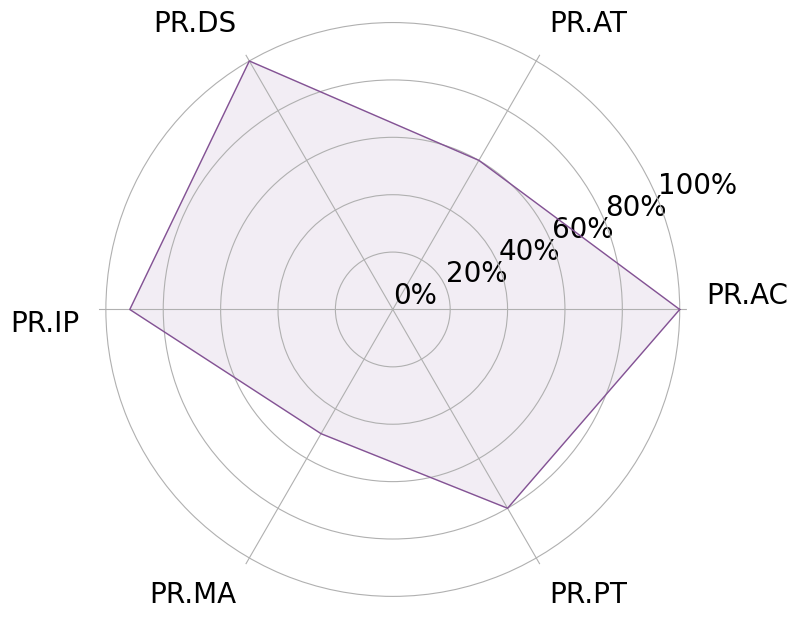

/var/folders/qb/z7q3w2md0c3c0s29ngj6p0600000gn/T/ipykernel_46176/1449897151.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


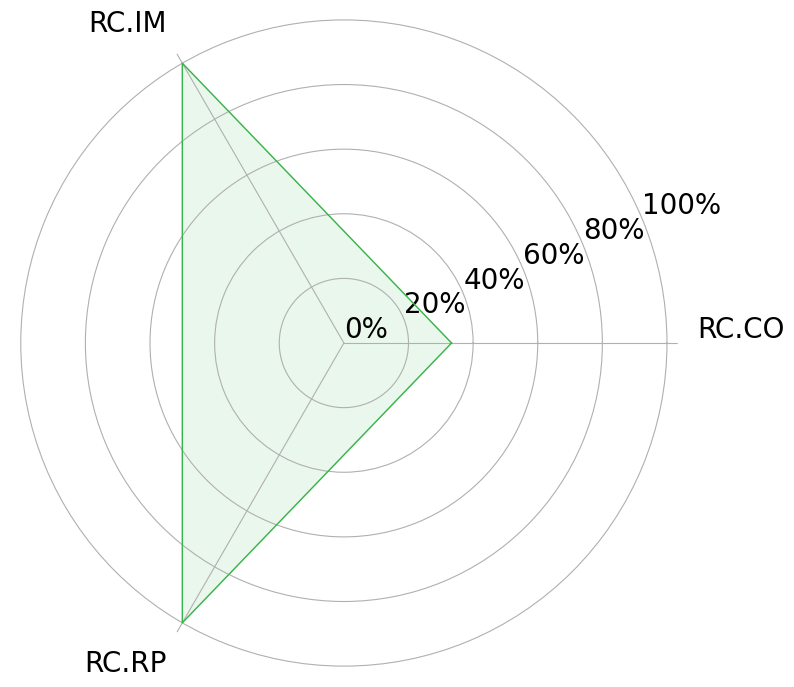

/var/folders/qb/z7q3w2md0c3c0s29ngj6p0600000gn/T/ipykernel_46176/1449897151.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


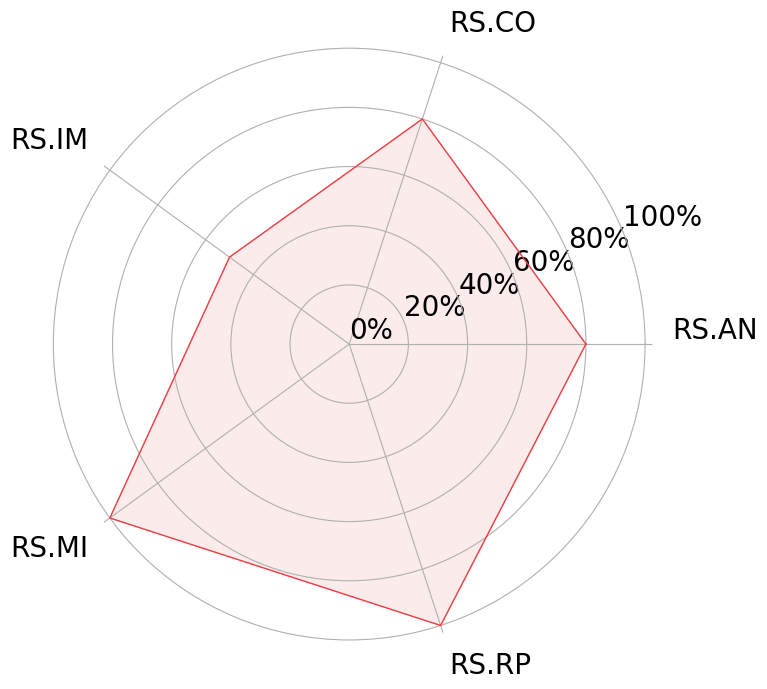

In [672]:
# Generate radar charts for each "Function"
for function, group_data in category_counts.groupby('Function'):
    plot_radar_chart(group_data, function)

In [660]:
# Grouping by 'Function' column
grouped_df = category_counts.groupby('Function').agg({
    'fulfilled': 'mean'
}).reset_index()

grouped_df

,Function,fulfilled
0,Detect,100.000000
1,Identify,66.111111
2,Protect,80.277778
3,Recover,77.777778
4,Respond,82.000000


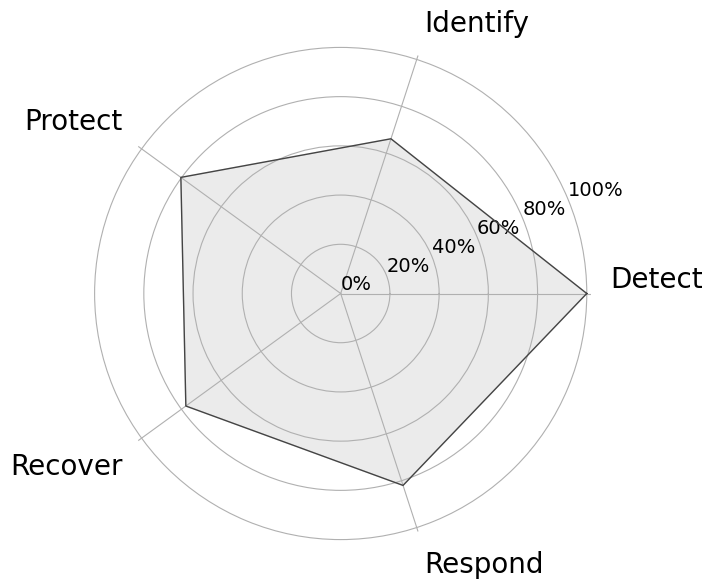

In [661]:

def plot_function_chart(data):
    # Number of functions
    num_functions = len(data)
    
    # Split the circle into even parts and save the angles 
    # so we know where to put each axis
    angles = np.linspace(0, 2 * np.pi, num_functions, endpoint=False).tolist()
    
    # Make the plot continuous
    values = data['fulfilled'].tolist() + data['fulfilled'].tolist()[:1]
    angles += angles[:1]
    
    # Set figure and axis
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    ax.set_aspect('equal')  # Set equal aspect ratio
    
    # Adjust the position of the subplot within the figure
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    # Define a generic color for the radar chart
    generic_color = '#444'
    
    ax.fill(angles, values, alpha=0.1, label="Fulfilled Values", color=generic_color)
    ax.plot(angles, values, linewidth=1, color=generic_color)
    
    # Set yticklabels with percentage
    yticks = np.linspace(0, 100, 6)
    ax.set_yticks(yticks)
    ax.set_yticklabels(["{:.0f}%".format(y) for y in yticks], fontsize=14)
    
    # Set xticklabels with fontsize and fontweight
    ax.set_xticks(angles[:-1])
    category_labels = data['Function']
    
    # Rotate the labels evenly
    rotation = [i * (360 / num_functions) for i in range(num_functions)]
    
    ax.set_xticklabels(category_labels, fontsize=20, rotation=0, ha='center', va='center')
    
    for label, angle_rad in zip(ax.get_xticklabels(), angles):
        angle_deg = np.degrees(angle_rad)
        if 0 <= angle_deg < 90:
            ha = 'left'
            va = 'bottom'
        elif 90 <= angle_deg < 180:
            ha = 'right'
            va = 'bottom'
        elif 180 <= angle_deg < 270:
            ha = 'right'
            va = 'top'
        else:
            ha = 'left'
            va = 'top'

        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)
    
    # Remove the border around the radar chart
    ax.spines['polar'].set_visible(False)
    
    # Adjust figure size here, after setting x-axis labels
    fig.set_size_inches(8, 6)
    
    # Adding a legend
    plt.tight_layout()
    
    # Export the plot as PDF
    plt.savefig("Overview.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
plot_function_chart(grouped_df)

In [664]:
df_citation_keys = pd.read_csv(coding, delimiter=";")
citation_keys = df_citation_keys['Key'].tolist()

def filter_bibtex_file(input_filename, output_filename, citation_keys):
    with open(input_filename, 'r') as infile, open(output_filename, 'w') as outfile:
        record = False
        for line in infile:
            if line.startswith('@'):
                # Extract the citation key from the current entry
                citation_key = line.split('{', 1)[1].split(',', 1)[0]
                # Check if the citation key is in the list of keys to include
                if citation_key in citation_keys:
                    record = True
                    outfile.write(line)
                else:
                    record = False
            elif record:
                outfile.write(line)

def check_missing_citation_keys(filename):
    with open(filename) as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)

    # Extract citation keys from the BibTeX file
    found_keys = [entry['ID'] for entry in bib_database.entries]

    # Find which citation keys are missing
    missing_keys = [key for key in citation_keys if key not in found_keys]

    if len(missing_keys) == 0:
        print("data is consistent")
    else:
        print(missing_keys)

# Call the function to filter the .bib file
filter_bibtex_file(all_references, selected_references, citation_keys)
check_missing_citation_keys(selected_references)

data is consistent


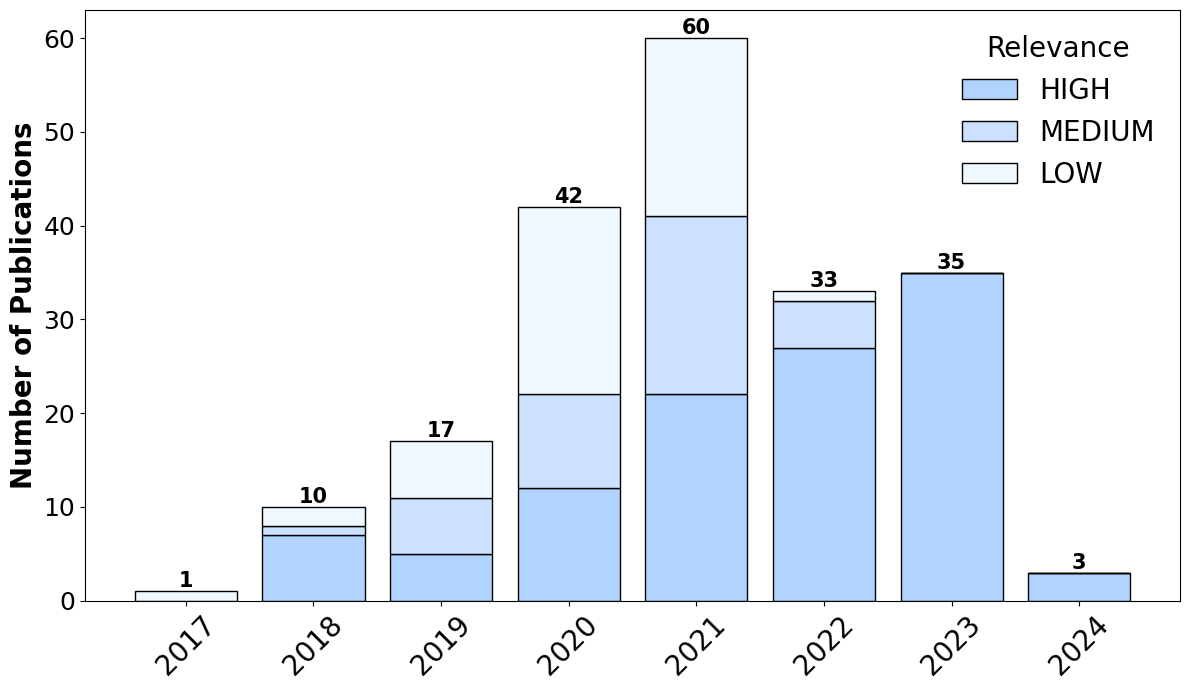

In [665]:
relevance_data = pd.read_csv(coding, delimiter=";")
relevance_mapping = dict(zip(relevance_data['Key'], relevance_data['Relevance']))

# Step 2: Read BibTeX file and extract publication years and keys
def extract_publication_data_with_relevance(filename, relevance_mapping):
    publication_data = []
    with open(filename) as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
        for entry in bib_database.entries:
            if 'year' in entry and entry['ID'] in relevance_mapping:
                publication_data.append((entry['year'], relevance_mapping[entry['ID']]))
    return publication_data

publication_data = extract_publication_data_with_relevance(selected_references, relevance_mapping)

# Step 3: Aggregate publication data by year and relevance
data_by_year_and_relevance = defaultdict(lambda: Counter({'HIGH': 0, 'MEDIUM': 0, 'LOW': 0}))
for year, relevance in publication_data:
    data_by_year_and_relevance[year][relevance] += 1

# Sorting years and preparing data for plotting
years = sorted(data_by_year_and_relevance.keys())
categories = ['HIGH', 'MEDIUM', 'LOW']  # Assuming these are the possible relevance levels

stacked_data = {category: [data_by_year_and_relevance[year][category] for year in years] for category in categories}

# Custom colors for each relevance category
colors = {
    'HIGH': '#B0D4FF',
    'MEDIUM': '#CCE0FF',
    'LOW': 'aliceblue',
}

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
bottom = [0] * len(years)
for category in categories:
    ax.bar(years, stacked_data[category], bottom=bottom, label=category, color=colors[category], edgecolor='black', linewidth=1)
    bottom = [bottom[i] + stacked_data[category][i] for i in range(len(years))]

# To add labels, we iterate over the 'years' since it directly corresponds to the x-ticks
for i, year in enumerate(years):
    height = bottom[i]  # Total height of the stack for the year
    if height > 0:  # Only add a label if the height is greater than 0
        ax.text(i, height, f'{height}', ha='center', va='bottom', fontsize=15, fontweight='bold')
        
plt.ylabel('Number of Publications', fontsize=20, fontweight='bold')
plt.xticks(range(len(years)), years, rotation=45, fontsize=20)
plt.yticks(fontsize=18)
ax.legend(title='Relevance', title_fontsize=20, fontsize=20, frameon=False)
plt.tight_layout()
plt.savefig("Publications.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [670]:
# Print counts of relevance levels
relevance_counts = Counter(relevance_mapping.values())
print(f"Highly Relevant: {relevance_counts['HIGH']}")
print(f"Medium Relevance: {relevance_counts['MEDIUM']}")
print(f"Low Relevance: {relevance_counts['LOW']}")

Highly Relevant: 111
Medium Relevance: 41
Low Relevance: 49
